### Pacman - Simple Map with Neural Network Shield

In [1]:
import random
import tkinter as tk
from tkinter import Canvas
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import matplotlib.pyplot as plt
from sklearn.utils import resample
from collections import deque
from datetime import datetime
import copy
import time

#### Utility Functions (Statistics, Time formating, Data importing/exporting)

In [2]:
def sum_rewards(reward_per_episode, episodes_completed):
    """Returns the reward for last 100 episodes for each episode"""
    sum_of_rewards = np.zeros(episodes_completed)
    for i in range(episodes_completed):
        # Rewards for last 100 episodes
        sum_of_rewards[i] = np.sum(reward_per_episode[max(0, i - 100):(i+1)])

    return sum_of_rewards

def cumulative_reward(rewards_per_episode):
    """Create a list of the cumulative reward the agent has gained per episode."""
    cumulative_reward = [rewards_per_episode[0]]
    for i in rewards_per_episode[1:]:
        cumulative_reward.append(i + cumulative_reward[-1])
        
    return cumulative_reward

def one_in_x(a_list, x):
    """Returns every one in x of a given list for purpose of smoothing reward graphs."""
    return a_list[::x]

def format_time(seconds):
    """Formats time in seconds into hours/minutes/seconds and returns a string of the resulting time."""
    minutes = int(seconds // 60)
    hours = int(minutes // 60)
    minutes = minutes % 60
    seconds = seconds % 60
    if hours > 0:
        return f"{hours} hours, {minutes} minute{'s' if minutes != 1 else ''}, {seconds:.2f} seconds"
    if minutes > 0:
        return f"{minutes} minute{'s' if minutes != 1 else ''}, {seconds:.2f} seconds"
    return f"{seconds:.2f} seconds"

def export_results(rewards, violations, save_name=None):
    """Function to export results to an Excel file."""
    # Create Pandas dataframe to hold results
    to_save = pd.DataFrame({"Rewards": rewards, "Violations": violations})
   
    # Export the DataFrame to Excel.
    if save_name:
        file_name = save_name + '.xlsx'
    else:
        file_name = "Results_" + datetime.now().strftime('%d.%m.%Y_%H.%M') + '.xlsx'
    writer = pd.ExcelWriter(file_name, engine='xlsxwriter')
    to_save.to_excel(writer, sheet_name='Sheet1', index=False)
    writer.close()
    print(f"Save sucessful: {file_name}. Episodes: {len(to_save)}")

def import_results(file_name):
    """Function to load results and violations from Excel and return as lists."""
    df = pd.read_excel(file_name)
    print(f"{file_name} imported. Episodes: {len(df)}")    
    return df['Rewards'].tolist(), df["Violations"].tolist()

def dec4(n):
    """Convert a number to a number with four decimal places."""
    return float(f"{n:.4f}")

#### Shielding
Safe class threshold of 0.52, Under sample Multiplier of 0.5 - Gaussian NB

In [3]:
class BinaryClassifier(nn.Module):
    """Neural Network to act as a Binary classifier for shield safety."""
    def __init__(self, dropout_probability=0.3):
        self.dropout = dropout_probability # Define dropout as a class atribute.
        super(BinaryClassifier, self).__init__() # Binary classifier used.
        self.hidden_layer_1 = nn.Linear(9, 64) # First hidden layer
        if self.dropout:
            self.dropout_layer_1 = nn.Dropout(p=self.dropout) # Dropout layer added if dropout active.
        self.hidden_layer_2 = nn.Linear(64, 32) # Second hidden layer
        if self.dropout:
            self.dropout_layer_2 = nn.Dropout(p=self.dropout) # Second dropout layer added if dropout active.
        self.output_layer = nn.Linear(32, 1) # Output layer
        self.sigmoid = nn.Sigmoid() # Sigmoid function
        self.relu = nn.ReLU() # Relu function

    def forward(self, x):
        # Feed forward through the network
        x = self.relu(self.hidden_layer_1(x))
        if self.dropout:
            x = self.dropout_layer_1(x)
        x = self.relu(self.hidden_layer_2(x))
        if self.dropout:
            x = self.dropout_layer_2(x)
        # Sigmoid function to output the probability of the experience being safe.
        x = self.sigmoid(self.output_layer(x))
        return x

In [4]:
class NNShield():
    """Shield class"""
    def __init__(self, threshold=None):
        self.train_count = 0
        self.threshold = threshold
        # Initialise model, loss, and optimiser.
        self.model = BinaryClassifier(0.2) # Dropout of 0.2 used.
        self.loss_ = nn.BCELoss() # Binary Cross-Entropy Loss
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)

    def train(self, data):
        # Function to train the classifier with new data.
        # Add column names to the data.
        data.columns = ["episode_number", "Pac_x", "Pac_y", "G1_x", "G1_y", "G2_x", "G2_y", "F_1", "F_2", "Action", "Safe"]
        
        data = data.tail(100000) # Only use last 100,000 experiences to speed up training of shield.
        
        X_train = data.drop(data.columns[[0, 10]], axis=1) # Drop columns 0 and 10 (episode and safe)
        Y_train = data["Safe"]
        
        # Convert to a numpy array, then to a Tensor, with reshaping for the targets(Y_train and Y_test).
        numpy_array = X_train.values # First, convert to a Numpy array.
        X_train = torch.tensor(numpy_array, dtype=torch.float32)
        numpy_array = Y_train.values
        Y_train = torch.tensor(numpy_array, dtype=torch.float32).view(-1, 1)
         
        # Create TensorDataset
        # Combines the input features and labels into a dataset object compatible with DataLoader.
        dataset = TensorDataset(X_train, Y_train)

        # Create a weighted random sampler to give more weight to the class with fewer samples (unsafe)
        class_counts = np.bincount(Y_train.squeeze().long()) # Count the number of instances of each class.
        class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float) # Calculate class weights.
        sample_weights = class_weights[Y_train.squeeze().long()] # Specify the weight for each sample.

        # Initialise the DataLoader
        dataloader = DataLoader(dataset, batch_size=32, sampler=WeightedRandomSampler(weights=sample_weights, num_samples=len(Y_train), replacement=True))

        self.model.train()
        for epoch in range(50):
            for inputs, labels in dataloader:
                outputs = self.model(inputs)
                loss = self.loss_(outputs, labels)
                self.optimizer.zero_grad() # Zero gradients.
                loss.backward() # Backpropagate through model.
                self.optimizer.step() # Optimise model.
        self.train_count += 1 # Increment training count.
    
    def predict(self, exp):
        # Fuction to make a prediction on a data point.
        self.model.eval()
        with torch.no_grad():
            # Run a forward pass through the model after converting the experience to a Tensor.
            output = self.model(torch.tensor(exp))
            
            # Compare to the threshold and return as 1.0 or 0.0.
            prediction = (output >= self.threshold).float()
            
            return prediction

    def train_count(self):
        return self.train_count

In [5]:
class ShieldMemory():
    """Class to store experiences:
    Format is (current_state, action, terminated)"""
    def __init__(self):
        self.memory = []
    
    def add_experience(self, exp):
        # Adds an experience to replay buffer.
        # Input format for exp: (state, action, safe, episode_number)
        # Experience format is a list of all of these combined. [episode_number, state, action, safe]
        experience = [exp[3]]
        for n in exp[0]:
            experience.append(n)
        experience.append(exp[1])
        experience.append(exp[2])
        
        self.memory.append(experience)
    
    def current_memories(self):
        # Returns how many memories are currently stored.
        return len(self.memory)
    
    def export_memories(self):
        """Function to export memories to an Excel file."""
        # Create Pandas datafram to hold results
        df = pd.DataFrame(self.memory)
        df.columns = ["Ep_#", "Pac_x", "Pac_y", "G1_x", "G1_y", "G2_x", "G2_y", "F_1", "F_2", "Actn", "Safe"]

        # Export the DataFrame to Excel.
        df.to_csv("Shield_Experience_" + datetime.now().strftime('%d.%m.%Y_%H.%M')+".csv")
        print("Save sucessful")
        
    def wipe_memory(self):
        # Wipe memory.
        self.memory = []

### Deep Q-Learning

In [6]:
class ExperienceReplay():
    """Class to store experiences for training purposes.
       Experiences are store in the format (current_state, action, new_state, reward, terminated)"""
    def __init__(self, memory_max=500000, batch_size=32):
        self.memory = deque([], maxlen=memory_max) # Maximum experiences stored
        self.batch_size = batch_size # Batch size
    
    def add_experience(self, exp):
        # Adds an experience to replay buffer.
        # Format (current_state, action, new_state, reward, terminated)
        self.memory.append(exp)
    
    def sample(self):
        # Returns a batch of samples from memory.
        return random.sample(self.memory, self.batch_size)
    
    def current_memories(self):
        # Returns how many memories are currently stored.
        return len(self.memory)


class DQN(nn.Module):
    """Class for the network model."""
    def __init__(self, in_states, out_actions):
        super().__init__()

        # Define network layers
        self.fc1 = nn.Linear(in_states, 32) 
        self.fc2 = nn.Linear(32, 16)
        self.out = nn.Linear(16, out_actions)

    def forward(self, x):
        # Forward pass through the network.
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.out(x)
        return x

class CoordinateMemory():
    # Class to store coordinates explored for exploration bonus purposes.
    def __init__(self):
        # Ititialise a set with Pacmans starting coordinates.
        self.memory = set((1, 1))
    
    def add(self, pos):
        # Adds an explored coordinate to memory and returns if it is newly explored.
        pos = tuple(pos)
        new = True # Is the coordinate newly explored, or not.
        if pos in self.memory:
            new = False
        self.memory.add(pos)
        
        return new

In [7]:
# Simple Pacman Map
# 1 = wall, 2 = food, 0 = empty space
INITIAL_MAZE = [
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1],
    [1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1],
    [1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1],
    [1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1],
    [1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1],
    [1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1],
    [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1],
    [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1],
    [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
]

# Directions for movement, including Stop
directions = {
    "North": [-1, 0],
    "South": [1, 0],
    "East": [0, 1],
    "West": [0, -1],
    "Stop": [0, 0]
}

# Relative directions for right-hand and left-hand rules
RIGHT_TURN = {
    "North": "East",
    "East": "South",
    "South": "West",
    "West": "North"
}

LEFT_TURN = {
    "North": "West",
    "West": "South",
    "South": "East",
    "East": "North"
}

OPPOSITE = {
    "North": "South",
    "South": "North",
    "East": "West",
    "West": "East"
}

# Game Settings
CELL_SIZE = 30
WINDOW_SIZE = len(INITIAL_MAZE) * CELL_SIZE
WALL_THICKNESS = 4
WALL_GAP = 2

# Ghost movement probability
GHOST_MOVE_PROBABILITY = 0.9

class WallFollowingGhost:
    """Class for the wall following ghosts movement policy. Largely generated by Grok 3
       Can be set to follow the left or right wall.
       
       Input: Colour, starting position, starting direction and follow side."""
    def __init__(self, color, start_pos, start_direction, follow_side="right"):
        self.color = color
        self.current_pos = start_pos
        self.direction = start_direction
        self.follow_side = follow_side

    def move(self, maze):
        row, col = self.current_pos
        if self.follow_side == "right":
            # Follow side is left.
            turn_dir = RIGHT_TURN[self.direction]
            straight_dir = self.direction
            left_dir = LEFT_TURN[self.direction]
            back_dir = OPPOSITE[self.direction]
            directions_to_try = [turn_dir, straight_dir, left_dir, back_dir]
        else:
            # Follow side is left
            turn_dir = LEFT_TURN[self.direction]
            straight_dir = self.direction
            right_dir = RIGHT_TURN[self.direction]
            back_dir = OPPOSITE[self.direction]
            directions_to_try = [turn_dir, straight_dir, right_dir, back_dir]

        for direction in directions_to_try:
            delta_row, delta_col = directions[direction]
            new_row = row + delta_row
            new_col = col + delta_col
            if (0 <= new_row < len(maze) and 0 <= new_col < len(maze[0]) and
                    maze[new_row][new_col] != 1):
                self.current_pos = [new_row, new_col]
                self.direction = direction
                break


class PacmanGame:
    """Class to handle and draw the Pacman game enviroment. Largely generated by Grok 3."""
    def __init__(self, root, num_ghosts=1, visualize=True):
        self.visualize = visualize
        self.root = root if visualize else None
        if visualize:
            self.canvas = Canvas(self.root, width=WINDOW_SIZE, height=WINDOW_SIZE, bg="black")
            self.canvas.pack()
        self.num_ghosts = max(1, min(4, num_ghosts))
        self.ghost_colors = ["red", "pink", "orange", "cyan"][:self.num_ghosts]
        self.ghost_start_positions = [[3, 5], [3, 10], [11, 4], [11, 10]][:self.num_ghosts] # Also set in self.ghosts
        self.ghosts = [
            # Red ghost (Blinky)
            WallFollowingGhost("red", [3, 5], "South", follow_side="right"),
            # Pink ghost (Pinky)
            WallFollowingGhost("pink", [3, 10], "South", follow_side="left"),
            # Orange ghost (Clyde)
            WallFollowingGhost("orange", [11, 4], "North", follow_side="right"),
            # Cyan ghost (Inky)
            WallFollowingGhost("cyan", [11, 10], "North", follow_side="left")
        ][:self.num_ghosts]
        self.ghost_positions = [ghost.current_pos for ghost in self.ghosts]
        self.ghost_modes = ["wall_following"] * self.num_ghosts
        self.state_size = 2 + 2 * self.num_ghosts
        self.action_size = 4
        self.actions = ["North", "South", "East", "West"] # Available actions
        self.reset_episode()

    def reset_episode(self):
        self.maze = [row[:] for row in INITIAL_MAZE]
        self.pacman_pos = [1, 1]  
        for i, ghost in enumerate(self.ghosts):
            ghost.current_pos = self.ghost_start_positions[i]
            if ghost.color == "red":
                ghost.current_pos = [3, 4]
                ghost.direction = "South"
            elif ghost.color == "pink":
                ghost.current_pos = [3, 10]
                ghost.direction = "South"
            elif ghost.color == "orange":
                ghost.current_pos = [11, 4]
                ghost.direction = "North"
            elif ghost.color == "cyan":
                ghost.current_pos = [11, 10]
                ghost.direction = "North"
        self.ghost_positions = [ghost.current_pos for ghost in self.ghosts]
        self.food_left = sum(row.count(2) for row in self.maze)  # Count only initial 2s
        self.running = True
        self.pacman_direction = "East"
        self.ghost_modes = ["wall_following"] * self.num_ghosts
        if self.visualize:
            self.draw_maze()
            self.draw_pacman()
            self.draw_ghosts()

    def draw_maze(self):
        if not self.visualize:
            return
        self.canvas.delete("all")
        rows, cols = len(self.maze), len(self.maze[0])
        for row in range(rows):
            for col in range(cols):
                x1, y1 = col * CELL_SIZE, row * CELL_SIZE
                x2, y2 = x1 + CELL_SIZE, y1 + CELL_SIZE
                if self.maze[row][col] == 2:
                    self.canvas.create_oval(x1 + 12, y1 + 12, x2 - 12, y2 - 12, fill="white")
                elif self.maze[row][col] == 1:
                    if row == 0 or self.maze[row-1][col] != 1:
                        self.canvas.create_line(x1, y1, x2, y1, fill="blue", width=WALL_THICKNESS)
                        self.canvas.create_line(x1, y1 + WALL_GAP, x2, y1 + WALL_GAP, fill="blue", width=WALL_THICKNESS)
                    if row == rows - 1 or self.maze[row+1][col] != 1:
                        self.canvas.create_line(x1, y2, x2, y2, fill="blue", width=WALL_THICKNESS)
                        self.canvas.create_line(x1, y2 - WALL_GAP, x2, y2 - WALL_GAP, fill="blue", width=WALL_THICKNESS)
                    if col == 0 or self.maze[row][col-1] != 1:
                        self.canvas.create_line(x1, y1, x1, y2, fill="blue", width=WALL_THICKNESS)
                        self.canvas.create_line(x1 + WALL_GAP, y1, x1 + WALL_GAP, y2, fill="blue", width=WALL_THICKNESS)
                    if col == cols - 1 or self.maze[row][col+1] != 1:
                        self.canvas.create_line(x2, y1, x2, y2, fill="blue", width=WALL_THICKNESS)
                        self.canvas.create_line(x2 - WALL_GAP, y1, x2 - WALL_GAP, y2, fill="blue", width=WALL_THICKNESS)

    def draw_pacman(self):
        """Function to draw the Pacman in the Pacman game. Generated by Grok 3"""
        if not self.visualize:
            return
        row, col = self.pacman_pos
        x, y = col * CELL_SIZE + CELL_SIZE // 2, row * CELL_SIZE + CELL_SIZE // 2
        radius = CELL_SIZE // 2 - 2
        if self.pacman_direction == "East":
            start, extent = 30, 300
        elif self.pacman_direction == "West":
            start, extent = 210, 300
        elif self.pacman_direction == "North":
            start, extent = 120, 300
        else:
            start, extent = 300, 300
        self.pacman = self.canvas.create_arc(
            x - radius, y - radius, x + radius, y + radius,
            start=start, extent=extent, fill="yellow", outline="yellow"
        )

    def draw_ghosts(self):
        """Function to draw the ghots in the Pacman game. Generated by Grok 3"""
        if not self.visualize:
            return
        self.ghosts_drawn = []
        for i, ghost in enumerate(self.ghosts):
            row, col = ghost.current_pos
            x, y = col * CELL_SIZE + CELL_SIZE // 2, row * CELL_SIZE + CELL_SIZE // 2
            radius = CELL_SIZE // 2 - 2
            points = []
            num_points = 10
            for j in range(num_points + 1):
                angle = np.pi * j / num_points
                px = x - radius * np.cos(angle)
                py = y - radius * np.sin(angle)
                points.append(px)
                points.append(py)
            points.extend([
                x + radius, y + radius - 5,
                x + radius * 0.75, y + radius,
                x + radius * 0.25, y + radius - 5,
                x - radius * 0.25, y + radius,
                x - radius * 0.75, y + radius - 5,
                x - radius, y + radius - 5,
                x - radius, y
            ])
            body = self.canvas.create_polygon(points, fill=ghost.color, outline=ghost.color, smooth=True)
            eye_radius = radius // 3
            pupil_radius = eye_radius // 2
            eye_y_offset = y - radius * 0.5
            self.canvas.create_oval(x - radius * 0.5 - eye_radius, eye_y_offset - eye_radius,
                                    x - radius * 0.5 + eye_radius, eye_y_offset + eye_radius,
                                    fill="white")
            self.canvas.create_oval(x + radius * 0.5 - eye_radius, eye_y_offset - eye_radius,
                                    x + radius * 0.5 + eye_radius, eye_y_offset + eye_radius,
                                    fill="white")
            self.canvas.create_oval(x - radius * 0.5 - pupil_radius, eye_y_offset - pupil_radius,
                                    x - radius * 0.5 + pupil_radius, eye_y_offset + pupil_radius,
                                    fill="black")
            self.canvas.create_oval(x + radius * 0.5 - pupil_radius, eye_y_offset - pupil_radius,
                                    x + radius * 0.5 + pupil_radius, eye_y_offset + pupil_radius,
                                    fill="black")
            self.ghosts_drawn.append(body)

    def get_legal_directions(self, pos):
        legal_directions = []
        for direction, (delta_row, delta_col) in directions.items():
            if direction == "Stop":
                continue
            new_row = pos[0] + delta_row
            new_col = pos[1] + delta_col
            if 0 <= new_row < len(self.maze) and 0 <= new_col < len(self.maze[0]) and self.maze[new_row][new_col] != 1:
                legal_directions.append(direction)
        return legal_directions

    def move_ghost(self, ghost_idx, ghost_pos):
        if random.random() > GHOST_MOVE_PROBABILITY:
            return
        if ghost_idx >= self.num_ghosts:
            return

        self.ghosts[ghost_idx].move(self.maze)
        self.ghost_positions[ghost_idx] = self.ghosts[ghost_idx].current_pos

    def move_pacman(self, action):
        """Function to control the agents movemnets on the grid when an action is given."""
        delta_row, delta_col = directions[action]
        new_row = self.pacman_pos[0] + delta_row
        new_col = self.pacman_pos[1] + delta_col
        reward = 0
        if action != "Stop":
            self.pacman_direction = action
        if 0 <= new_row < len(self.maze) and 0 <= new_col < len(self.maze[0]) and self.maze[new_row][new_col] != 1:
            self.pacman_pos[0] = new_row
            self.pacman_pos[1] = new_col
            if self.maze[new_row][new_col] == 2:
                self.maze[new_row][new_col] = 0
                self.food_left -= 1
                reward = 1 # Reward for collecting food
        return reward


    def get_state(self, tensor=True):
        """Function to return a Tensor of the state of the environment.
           This is in the format of pacmans coordinates, then each ghosts coordinates,
           then if two pieces of food are present.
           returned as a Tensor for neural network input or a list for shielding purposes.
           Written by PBN"""
        observations = [] # The state to be returned
        
        # Add Pacmans's x and y coordinates.
        observations.append(dec4(self.pacman_pos[1]/14)) # Pacmans's X position
        observations.append(dec4(self.pacman_pos[0]/6)) # Pacmans's Y position
        # Add each Ghost's x and y coordinates. Normalised (with /14 and /6).
        for i, ghost_pos in enumerate(self.ghost_positions):
            observations.append(dec4(ghost_pos[1]/14))
            observations.append(dec4(ghost_pos[0]/6))
        # Add if each food is still present.
        if self.maze[3][7] == 2:
            observations.append(1) # Piece of food 1
        else:
            observations.append(0)
        if self.maze[1][12] == 2:
            observations.append(1) # Piece of food 2
        else:
            observations.append(0)

        if tensor:
            return torch.FloatTensor(observations)
        else:
            return observations
    

    
    def step(self, action):
        """Function to perform one step in the environment with the givven action.
           The position of the agent (Pacman) and the hazards (Ghosts) is updated.
           The status of any eaten food is also updated."""
        if self.running:
            reward = self.move_pacman(action) # Reward if food is eaten.
            for idx, ghost_pos in enumerate(self.ghost_positions):
                self.move_ghost(idx, ghost_pos)

            new_state = self.get_state()
            terminated = False
            if any(self.pacman_pos == ghost_pos for ghost_pos in self.ghost_positions):
                # Check if Pacman is in the same position as any ghosts.
                self.running = False
                terminated = True
            elif self.food_left == 0:
                # If food left is zero, Pacman has won the game.
                self.running = False
                terminated = True

            if self.visualize:
                self.draw_maze()
                self.draw_pacman()
                self.draw_ghosts()

        return new_state, reward, terminated


def run_episodes(num_episodes, num_ghosts=1, visualize=True, move_limit=100, random_actions=False, DDQN=False, nb_shield=False, mult=1, threshold=None):
    # Training using the Pacman environment by Grok 3 with DQN/DDQN network.
    total_start_time = time.time()
    epsilon = 1 # E-greedy starting policy, starting at 100% randomised movement.
    decay = 0.0001 # Epsilon decay per episode [0.0001=10,000 episodes]
    root = tk.Tk() if visualize else None
    if visualize:
        root.title(f"Pac-Man with {num_ghosts} Ghost(s)")
    game = PacmanGame(root, num_ghosts, visualize)
    actions = ["North", "South", "East", "West"]
    
    # Statistics
    violations = 0 # Safety violations.
    timeouts = 0 # Amount of time the move limit is hit.
    reward_per_episode = []
    violations_per_episode = []
    steps_count = 0
    
    # DQN
    loss_function = nn.MSELoss()
    memory = ExperienceReplay()
    discount_factor = 0.9 # The % of the reward that is propagated back to the the previous state.
    learning_rate = 0.001 # Learning rate for DQN.
    network_sync_rate = 100 # The rate at which the policy and target networks syncronise.
    input_len = 8
    num_actions = 4
    memory = ExperienceReplay() # Initialise Experience Replay.
    step_count = 0 # Steps between each target network update.

    # Create policy and target network
    policy_dqn = DQN(in_states=input_len, out_actions=num_actions)
    target_dqn = DQN(in_states=input_len, out_actions=num_actions)
    target_dqn.load_state_dict(policy_dqn.state_dict()) # Copy target networks weights from policy network.
    optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=learning_rate) # Set Adam optimiser.
    
    # Shielding Functionality
    shield_memory = ShieldMemory() # Initialise Shield memory storage.
    shield = NNShield(threshold) # Initialise Shield
    
    
    def optimize(mini_batch, policy_dqn, target_dqn):
        # Function to perform one training step.
        current_q_list = [] # List of current calculated q values.
        target_q_list = [] # List of target q values.

        for state, action, new_state, reward, terminated in mini_batch:
            if reward != 0 or terminated:
                target = torch.FloatTensor([reward])
            else:
                # Calculate Q value using Double DQN Algorithm.
                # Get best action from the policy network.
                if DDQN:
                    best_action = policy_dqn(state).argmax()
                    with torch.no_grad():
                        target = torch.FloatTensor(reward + discount_factor * target_dqn(new_state)[best_action])
                else: 
                    # Calculate Q value for DQN.
                    with torch.no_grad():
                        target = torch.FloatTensor(reward + discount_factor * target_dqn(new_state).max())
        
            # Get the current set of Q values
            current_q = policy_dqn(state)
            current_q_list.append(current_q)

            # Get the target set of Q values
            target_q = target_dqn(state)
            target_q[action] = target
            target_q_list.append(target_q)
        
        # Compute loss for the whole minibatch
        loss = loss_function(torch.stack(current_q_list), torch.stack(target_q_list))
        
        # Optimise the model
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()
        optimizer.step()
        
    
    for episode in range(1, num_episodes + 1):
        # Train for required number of episodes.
        steps = 0
        total_reward = 0

        # Exploration Bonus Coordinate Storage
        exp_memory = CoordinateMemory()
        
        if (episode) % 30000 == 0:
            this_time = time.time()
            print(f"Time {format_time(time.time() - total_start_time)} Starting Episode {episode}...")
            
        game.reset_episode() # Reset environment to initial state.  
        state = game.get_state() # Get initial game state.
        while game.running:
            random_action = False
            if random.uniform(0, 1) > epsilon and not random_actions:
                # Select best action
                with torch.no_grad():
                    action_ind = policy_dqn(state).argmax().item()
                    if nb_shield:
                        # Get list of Actions sorted in descending Q-value order.
                        q_vals = policy_dqn(state).tolist() # Get Q-values for current state.
                        ind_q_vals = list(enumerate(q_vals)) # Enumerate to get index of each value.
                        sorted_indices = [ind for ind, val in sorted(ind_q_vals, key=lambda x: x[1], reverse=True)]
                    action = actions[action_ind]
            else:
                # Random action
                action = random.sample(actions, 1)[0]
                random_action = True
            
            """Shield Functionality"""
            if nb_shield:       
                # Get state for shield in list format.
                shield_state = game.get_state(False) 
            
            if nb_shield and shield.train_count > 0 and not random_action:
                # Only activate shield if it has been trained at least once and is not a random action.
                if not random_action:
                    for action_ind in sorted_indices:
                        # If no action deemed safe, original action will be taken
                        pred_state = shield_state.copy()
                        pred_state.append(action_ind)

                        # Make prediction of the safety of the action.
                        safe = shield.predict(pred_state)
                        if safe:
                            # If action is deemed safe, break loop, that action will be taken.
                            action = actions[action_ind]
                            break


            # Take action
            new_state, reward, terminated = game.step(action)
            
            new_exploration = exp_memory.add(game.pacman_pos)
            if new_exploration:
                # Extra reward is new coordinates explored.
                reward += 0.1

            total_reward += reward
            
            steps += 1 # Increment step counter
            step_count += 1 # Increment target network step counter
            steps_count += 1
            
            if steps > move_limit:
                # Truncate episode if move limit is hit.
                game.running = False
            
            # Save experience to memory
            # Convert action back to it's relevant index.
            action_ind = actions.index(action)
            #Format (current_state, action, new_state, reward, terminated)
            memory.add_experience((state, action_ind, new_state, reward, terminated))
            
            if nb_shield:
                # Save experience to shield memory
                if terminated and reward < 0.2:
                    # If terminated and a low reward, must have hit a ghost
                    safe = 0
                else:
                    safe = 1
                shield_memory.add_experience((shield_state, action_ind, safe, episode))

            # New state becomes current state.
            state = new_state
            
            if episode > 1000:
                # Decrease epsilon after each episode to min of 0.05.
                epsilon = max(epsilon - decay, 0.05)
            
            if visualize and root:
                root.update()
                root.after(100)

        
        # Check the outcome of the episode.
        if any(game.pacman_pos == ghost_pos for ghost_pos in game.ghost_positions):
            outcome = "Lost (caught by ghost)"
        elif game.food_left == 0:
            outcome = "Won (ate all food)"
        else:
            outcome = f"Exceeded {move_limit} moves"
    
        # Track reward and safety violations.
        reward_per_episode.append(total_reward)
        if outcome == "Lost (caught by ghost)":
            violations += 1 # Track violations.
            violations_per_episode.append(1)
        else:
            violations_per_episode.append(0)
        
        if outcome == f"Exceeded {move_limit} moves":
            timeouts += 1 # Track move limit violations.
            
        if not random_actions:
            # Check if enough experience has been collected.
            if memory.current_memories() > 32:
                mini_batch = memory.sample() # Collect a sample of data.
                optimize(mini_batch, policy_dqn, target_dqn) # Train networks with sample.

                # Update target network weights to policy network weights every x steps.
                if step_count > network_sync_rate:
                    target_dqn.load_state_dict(policy_dqn.state_dict())
                    step_count = 0 # Reset counter
                    
        if episode % 10000 == 0 and nb_shield:
            #print(f"Training shield at episode {episode}, current samples {shield_memory.current_memories()}, {episode - violations - timeouts} episodes won.")
            # Convert current shield memory to a dataframe
            training_data = pd.DataFrame(shield_memory.memory)
            
            # Train shield with the data and wipe the memory as data has been used.
            shield.train(training_data)
            shield_memory.wipe_memory()
            #print(f"Training complete - Current samples {shield_memory.current_memories()}")
            
         
    # print("Shield memories:", shield_memory.current_memories())
    # print("Exporting shield data")
    # shield_memory.export_memories() ------------------------------------------------------------ MEMORY EXPORT FOR SHIELD
    
    total_end_time = time.time()
    total_duration = total_end_time - total_start_time
    #print(f"\nRuntime for {num_episodes} episodes: {format_time(total_duration)}")
    #print(f"{format_time(total_duration/num_episodes)} per episode")
    print(f"{num_episodes - violations - timeouts} episodes won.")
    print(f"Total safety violations: {violations}")
    print(f"Move limit hit: {timeouts}")
    print(f"Step count {steps_count}")
    print()
    if visualize and root:
        root.destroy()
    
    return reward_per_episode, violations, violations_per_episode, steps_count

#### DQN Training

In [8]:
# Settings
NUM_EPISODES = 120000 # Number of episodes to train for
TRAINING_RUNS = 3 # Number of training runs
NUM_GHOSTS = 2 # Number of ghosts present (2 simple, 3 in advanced)
VISUALIZE = False # Option to visualise training
MOVE_LIMIT = 200 # Maximum moves agent can make before episode truncation
RANDOM = False # Random actions toggle
DDQN = True # DDQN toggle (False reverts to DQN algorithm)
NAIVE_BAYES = True # Neural Network Shield shield active
MULT = 0.5 # Data balancing multiplier
THRESHOLD = 0.4 # Safe class probability threshold

In [63]:
# Import DDQN results for comparison
average_rewards, average_violations = import_results("Z_DDQN_1k.xlsx")

Z_DDQN_1k.xlsx imported. Episodes: 120000


##### Neural Network Shield training

In [10]:
print("Starting Neural Network Shield training...")
t1 = time.time()
all_rewards_NB = []
all_violations_NB = []
all_total_violations = 0
all_steps = 0

for i in range(TRAINING_RUNS):
    # Sum the runs and divide by number of runs to get the mean.
    rewards_ddqn, total_violations, violations_per_episode_NB, total_steps = run_episodes(NUM_EPISODES, NUM_GHOSTS, VISUALIZE, MOVE_LIMIT, RANDOM, DDQN, NAIVE_BAYES, MULT, THRESHOLD)
    rew_100_ddqn = sum_rewards(rewards_ddqn, NUM_EPISODES)
    all_rewards_NB.append(rew_100_ddqn)
    all_violations_NB.append(violations_per_episode_NB)
    all_total_violations += total_violations
    all_steps += total_steps
    
average_rewards_NB = []
average_violations_NB = []
for i in range(NUM_EPISODES):
    # Sum the runs and divide by number of runs to get the mean.
    total = sum([j[i] for j in all_rewards_NB])
    total_v = sum([j[i] for j in all_violations_NB])
    average_rewards_NB.append(total/TRAINING_RUNS)
    average_violations_NB.append(total_v/TRAINING_RUNS)
    
    
t2 = time.time()
print("***** Training Ended *****")
print("Average violations per run: ", all_total_violations/TRAINING_RUNS)
print(f"Naive Bayes with DDQN training time: {format_time(t2 - t1)}")
print("Average steps", (all_steps/TRAINING_RUNS/NUM_EPISODES))

# # Export results # "Naive_Bayes Shield_with_DDQN_120k_3_runs"
export_results(average_rewards_NB, average_violations_NB, "NN_Shield_120k_3_runs")

Starting Neural Network Shield training...
Time 31 minutes, 36.74 seconds Starting Episode 30000...
Time 1 hours, 11 minutes, 9.96 seconds Starting Episode 60000...
Time 1 hours, 49 minutes, 43.75 seconds Starting Episode 90000...
Time 2 hours, 30 minutes, 14.61 seconds Starting Episode 120000...
83341 episodes won.
Total safety violations: 34460
Move limit hit: 2199
Step count 3789684

Time 35 minutes, 41.63 seconds Starting Episode 30000...
Time 1 hours, 13 minutes, 40.14 seconds Starting Episode 60000...
Time 1 hours, 49 minutes, 18.34 seconds Starting Episode 90000...
Time 2 hours, 24 minutes, 57.63 seconds Starting Episode 120000...
85020 episodes won.
Total safety violations: 34499
Move limit hit: 481
Step count 3316962

Time 35 minutes, 42.79 seconds Starting Episode 30000...
Time 1 hours, 15 minutes, 46.53 seconds Starting Episode 60000...
Time 1 hours, 54 minutes, 54.41 seconds Starting Episode 90000...
Time 2 hours, 32 minutes, 28.85 seconds Starting Episode 120000...
93320 e

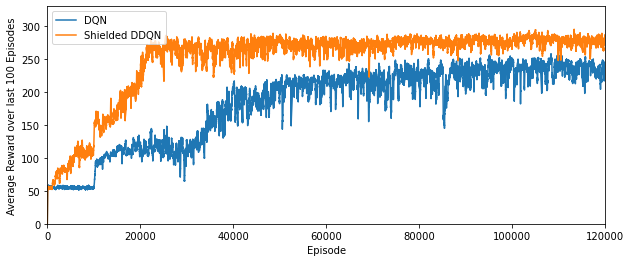

In [11]:
# Plot graph of results.
plt.rcParams['figure.figsize'] = [10, 4]
plt.plot(average_rewards, label="DQN")
plt.plot(average_rewards_NB, label="Shielded DDQN") 
plt.ylim(0, 330)
plt.xlim(0, NUM_EPISODES)
plt.legend(loc="upper left")
plt.ylabel('Average Reward over last 100 Episodes')
plt.xlabel('Episode')
plt.show()

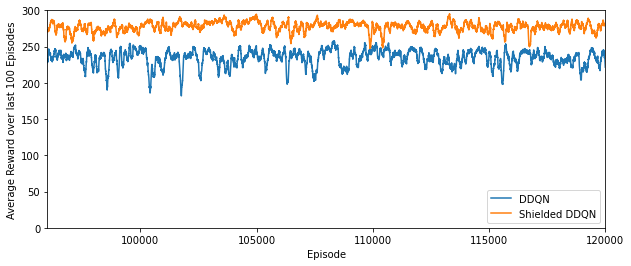

In [12]:
# Zoomed in results
plt.plot(average_rewards, label="DDQN")
plt.plot(average_rewards_NB, label="Shielded DDQN") 
plt.ylim(0, 300)
plt.xlim((NUM_EPISODES/5*4), NUM_EPISODES)
plt.legend(loc="lower right")
plt.ylabel('Average Reward over last 100 Episodes')
plt.xlabel('Episode')
plt.show()

In [69]:
# Import Naive Bayes results for comparison.
average_rewards_ANB, average_violations_ANB = import_results("Z_Naive_Bayes_runs_1k.xlsx")

Z_Naive_Bayes_runs_1k.xlsx imported. Episodes: 120000


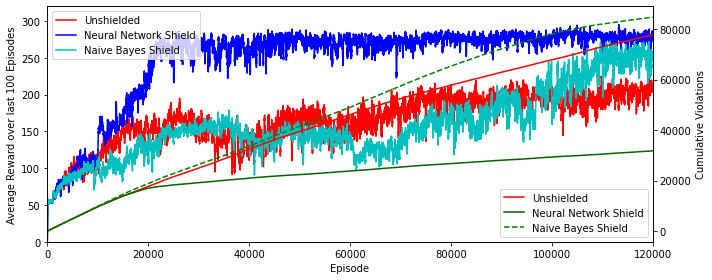

In [70]:
# Plot rewards and violations.
figure, axis_1 = plt.subplots()
plt.xlim(0, 120000)
plt.ylim(0, 320)
axis_1.plot(average_rewards, 'red', label='Unshielded')
axis_1.plot(average_rewards_NB, 'blue', label='Neural Network Shield')
axis_1.plot(average_rewards_ANB, 'c', label='Naive Bayes Shield')
axis_1.set_xlabel('Episode')
axis_1.set_ylabel('Average Reward over last 100 Episodes', color='black')
axis_2 = axis_1.twinx()
axis_2.plot(cumulative_reward(average_violations), 'red', label='Unshielded')
axis_2.plot(cumulative_reward(average_violations_NB), 'darkgreen', label='Neural Network Shield')
axis_2.plot(cumulative_reward(average_violations_ANB), 'g--', label='Naive Bayes Shield')
axis_2.set_ylabel('Cumulative Violations', color='black')
axis_1.legend(loc='upper left')
axis_2.legend(loc='lower right')
figure.tight_layout()
plt.show()

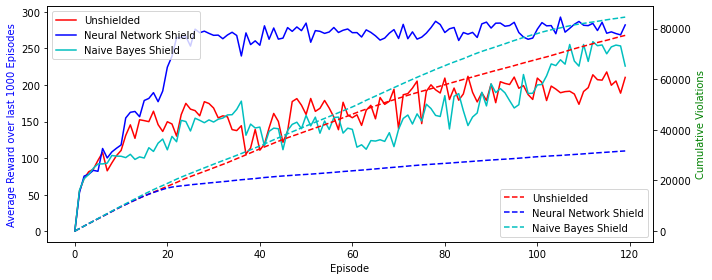

In [71]:
# Plot rewards and violations with 1 in 1,000 points plotted.
x = 1000
figure, axis_1 = plt.subplots()
axis_1.plot(one_in_x(average_rewards, x), 'r', label='Unshielded')
axis_1.plot(one_in_x(average_rewards_NB, x), 'b', label='Neural Network Shield')
axis_1.plot(one_in_x(average_rewards_ANB, x), 'c', label='Naive Bayes Shield')
axis_1.set_xlabel('Episode')
axis_1.set_ylabel('Average Reward over last 1000 Episodes', color='b')
axis_2 = axis_1.twinx()
axis_2.plot(one_in_x(cumulative_reward(average_violations), x), 'r--', label='Unshielded')
axis_2.plot(one_in_x(cumulative_reward(average_violations_NB), x), 'b--', label='Neural Network Shield')
axis_2.plot(one_in_x(cumulative_reward(average_violations_ANB), x), 'c--', label='Naive Bayes Shield')
axis_2.set_ylabel('Cumulative Violations', color='g')
axis_1.legend(loc='upper left')
axis_2.legend(loc='lower right')
figure.tight_layout()
plt.show()

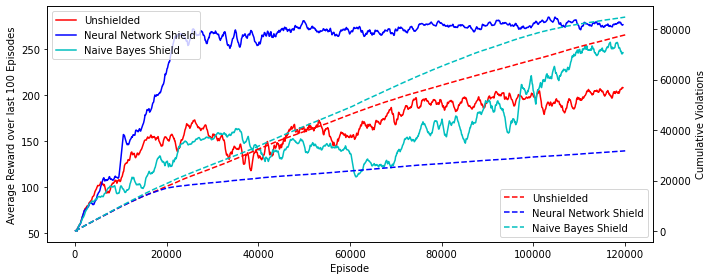

In [72]:
# Plot rewards and violations smoothed over the last 2,000 data points.
mean_ = 1000
shift_ = int(mean_ * -0.5)
figure, axis_1 = plt.subplots()
average_rewards_series = pd.Series(average_rewards)
average_rewards_NB_series = pd.Series(average_rewards_NB)
average_rewards_ANB_series = pd.Series(average_rewards_ANB)
axis_1.plot(average_rewards_series.rolling(mean_).mean().shift(shift_), 'r', label='Unshielded')
axis_1.plot(average_rewards_NB_series.rolling(mean_).mean().shift(shift_), 'b', label='Neural Network Shield')
axis_1.plot(average_rewards_ANB_series.rolling(mean_).mean().shift(shift_), 'c', label='Naive Bayes Shield')
axis_1.set_xlabel('Episode')
axis_1.set_ylabel('Average Reward over last 100 Episodes', color='black')
axis_2 = axis_1.twinx()
axis_2.plot(cumulative_reward(average_violations), 'r--', label='Unshielded')
axis_2.plot(cumulative_reward(average_violations_NB), 'b--', label='Neural Network Shield')
axis_2.plot(cumulative_reward(average_violations_ANB), 'c--', label='Naive Bayes Shield')
axis_2.set_ylabel('Cumulative Violations', color='black')
axis_1.legend(loc='upper left')
axis_2.legend(loc='lower right')
figure.tight_layout()
plt.show()